In [ ]:
from google.colab import files
uploaded = files.upload()

Saving convolutional_models.py to convolutional_models.py
Saving sequential_models.py to sequential_models.py
Saving unet_parts.py to unet_parts.py


In [ ]:
uploaded = files.upload()

Saving reverb_dataset.py to reverb_dataset.py
Saving utils.py to utils.py


In [ ]:
!pip install soundfile
!pip install librosa==0.8.0
!pip install scipy==1.5.2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import librosa
import librosa.display as display
import soundfile as sf
import os
import sys
import torch
import cv2

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import random
from utils import generate_spec, reconstruct_wave, graph_spec, split_for_supression, \
                  normalize_per_frame, denormalize_per_frame   
from reverb_dataset import ReverbDataset
from sequential_models import SupLSTM

     |████████████████████████████████| 25.9MB 1.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [ ]:
!pip install SciencePlots

  Created wheel for SciencePlots: filename=SciencePlots-1.0.7-cp37-none-any.whl size=5460 sha256=816c2a965e471e2e4b2da2537c758903ac1735580ce6be07266c498fb7079c8f
  Stored in directory: /root/.cache/pip/wheels/65/01/f1/d910b2dd79844adab51de69f6f753cd10af4d0563e9ef19a24
Successfully built SciencePlots


In [ ]:
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto ghostscript-x apache2 | lighttpd | httpd poppler-utils
  fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arph

# Data

Need at least 16 GB RAM for the 4 tensors. You can generate the tensors with data_generation notebooks (Generate_spectrograms.ipynb and Normalize_spectrograms.ipynb)

Load a smaller file number (for train) if you have less RAM

In [ ]:
X_train1 = torch.load('/content/drive/My Drive/data_audio/non_norm_data/X_train_1.pth')
X_train2 = torch.load('/content/drive/My Drive/data_audio/non_norm_data/X_train_2.pth')
X_train3 = torch.load('/content/drive/My Drive/data_audio/non_norm_data/X_train_3.pth')
X_train4 = torch.load('/content/drive/My Drive/data_audio/non_norm_data/X_train_4.pth')
y_train1 = torch.load('/content/drive/My Drive/data_audio/non_norm_data/y_train_1.pth')
y_train2 = torch.load('/content/drive/My Drive/data_audio/non_norm_data/y_train_2.pth')
y_train3 = torch.load('/content/drive/My Drive/data_audio/non_norm_data/y_train_3.pth')
y_train4 = torch.load('/content/drive/My Drive/data_audio/non_norm_data/y_train_4.pth')

In [ ]:
X = torch.cat((X_train1, X_train2, X_train3, X_train4))
y = torch.cat((y_train1, y_train2, y_train3, y_train4))

# Training

In [ ]:
def trainer_sec(model, train_loader, val_loader, checkpoints, nEpochs = 100, lr = 1e-3):
  """
  Train model

  model: LSTM based neural network
  train_loader: dataloader containing train examples
  val_loader: dataloader containing validation examples
  checkpoints: list of directories to save the model, train loss and Val loss respectively
  """

  criterion = nn.MSELoss()
  beta1 = 0.5
  beta2 = 0.999
  lr_decay = 0.97
  decay_rate = 2

  optimizer = torch.optim.Adam(model.parameters(), lr, (beta1, beta2))

  train_loss = []
  val_loss = []
  
  model.train()
  for epoch in range(nEpochs):
    temp_train_loss = 0.0
    corrects_train = 0
    for i, (rev_data, clean_data) in enumerate(train_loader):
      rev_data, clean_data = split_for_supression(rev_data, clean_data)
      rev_data, _ = normalize_per_frame(rev_data)
      clean_data, _ = normalize_per_frame(clean_data)
      rev_data = rev_data.cuda()
      clean_data = clean_data.cuda()
      optimizer.zero_grad()
      output = model(rev_data)
      loss_train = criterion(output, clean_data)
      loss_train.backward()
      optimizer.step()

      temp_train_loss += loss_train.item()

    temp_val_loss = 0.0    
    #Validacion
    model.eval()
    with torch.no_grad():
      for i, (rev_data, clean_data) in enumerate(val_loader):
        rev_data, clean_data = split_for_supression(rev_data, clean_data)
        rev_data, _ = normalize_per_frame(rev_data)
        clean_data, _ = normalize_per_frame(clean_data)
        rev_data = rev_data.cuda()
        clean_data = clean_data.cuda()

        output = model(rev_data)
        loss_val = criterion(output, clean_data)
        temp_val_loss += loss_val.item()

    train_loss.append(temp_train_loss)
    val_loss.append(temp_val_loss)

    print('Epoch : {} || Train Loss: {:.3f} || Val Loss: {:.3f}'\
         .format(epoch+1, loss_train.item(), loss_val.item()))
    model.train()
    
    if ((epoch+1)%5 == 0):
      torch.save(model.state_dict(), checkpoints[0])
      torch.save(train_loss, checkpoints[1])
      torch.save(val_loss, checkpoints[2])
      print("saved models")

    if (epoch % decay_rate == 1):
       optimizer.param_groups[0]['lr'] *= lr_decay

  return train_loss, val_loss

In [ ]:
total_dataset = ReverbDataset(X, y)
length_train = int(len(total_dataset)*0.85)
length_val = len(total_dataset) - length_train
lengths = [length_train, length_val]
dataset_train, dataset_val = random_split(total_dataset, lengths)

In [ ]:
print(len(dataset_train))
print(len(dataset_val))

17000
3000


In [ ]:
train_loader = DataLoader(dataset_train, batch_size = 1, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(dataset_val, batch_size = 1, shuffle = True, num_workers = 4, pin_memory = True)

In [ ]:
net = SupLSTM()
net = net.cuda()

checkpoints = ['/content/drive/My Drive/data_audio/models/suplstm_state_dict.pth', '/content/drive/My Drive/data_audio/losses/train_loss_suplstm.pth', 
               '/content/drive/My Drive/data_audio/losses/val_loss_suplstm.pth']

#329 frames = 1 specgram
train_loss, val_loss = trainer_sec(net, train_loader, val_loader, checkpoints, nEpochs = 50, lr=2e-4)

Epoch : 1 || Train Loss: 0.139 || Val Loss: 0.095
Epoch : 2 || Train Loss: 0.096 || Val Loss: 0.196
Epoch : 3 || Train Loss: 0.281 || Val Loss: 0.141
Epoch : 4 || Train Loss: 0.080 || Val Loss: 0.137
Epoch : 5 || Train Loss: 0.090 || Val Loss: 0.186
saved models
Epoch : 6 || Train Loss: 0.095 || Val Loss: 0.165
Epoch : 7 || Train Loss: 0.169 || Val Loss: 0.073
Epoch : 8 || Train Loss: 0.159 || Val Loss: 0.186
Epoch : 9 || Train Loss: 0.108 || Val Loss: 0.098
Epoch : 10 || Train Loss: 0.285 || Val Loss: 0.094
saved models
Epoch : 11 || Train Loss: 0.175 || Val Loss: 0.162
Epoch : 12 || Train Loss: 0.136 || Val Loss: 0.156
Epoch : 13 || Train Loss: 0.185 || Val Loss: 0.073
Epoch : 14 || Train Loss: 0.086 || Val Loss: 0.137
Epoch : 15 || Train Loss: 0.122 || Val Loss: 0.363
saved models
Epoch : 16 || Train Loss: 0.171 || Val Loss: 0.138
Epoch : 17 || Train Loss: 0.124 || Val Loss: 0.128
Epoch : 18 || Train Loss: 0.105 || Val Loss: 0.088
Epoch : 19 || Train Loss: 0.235 || Val Loss: 0.133
E

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


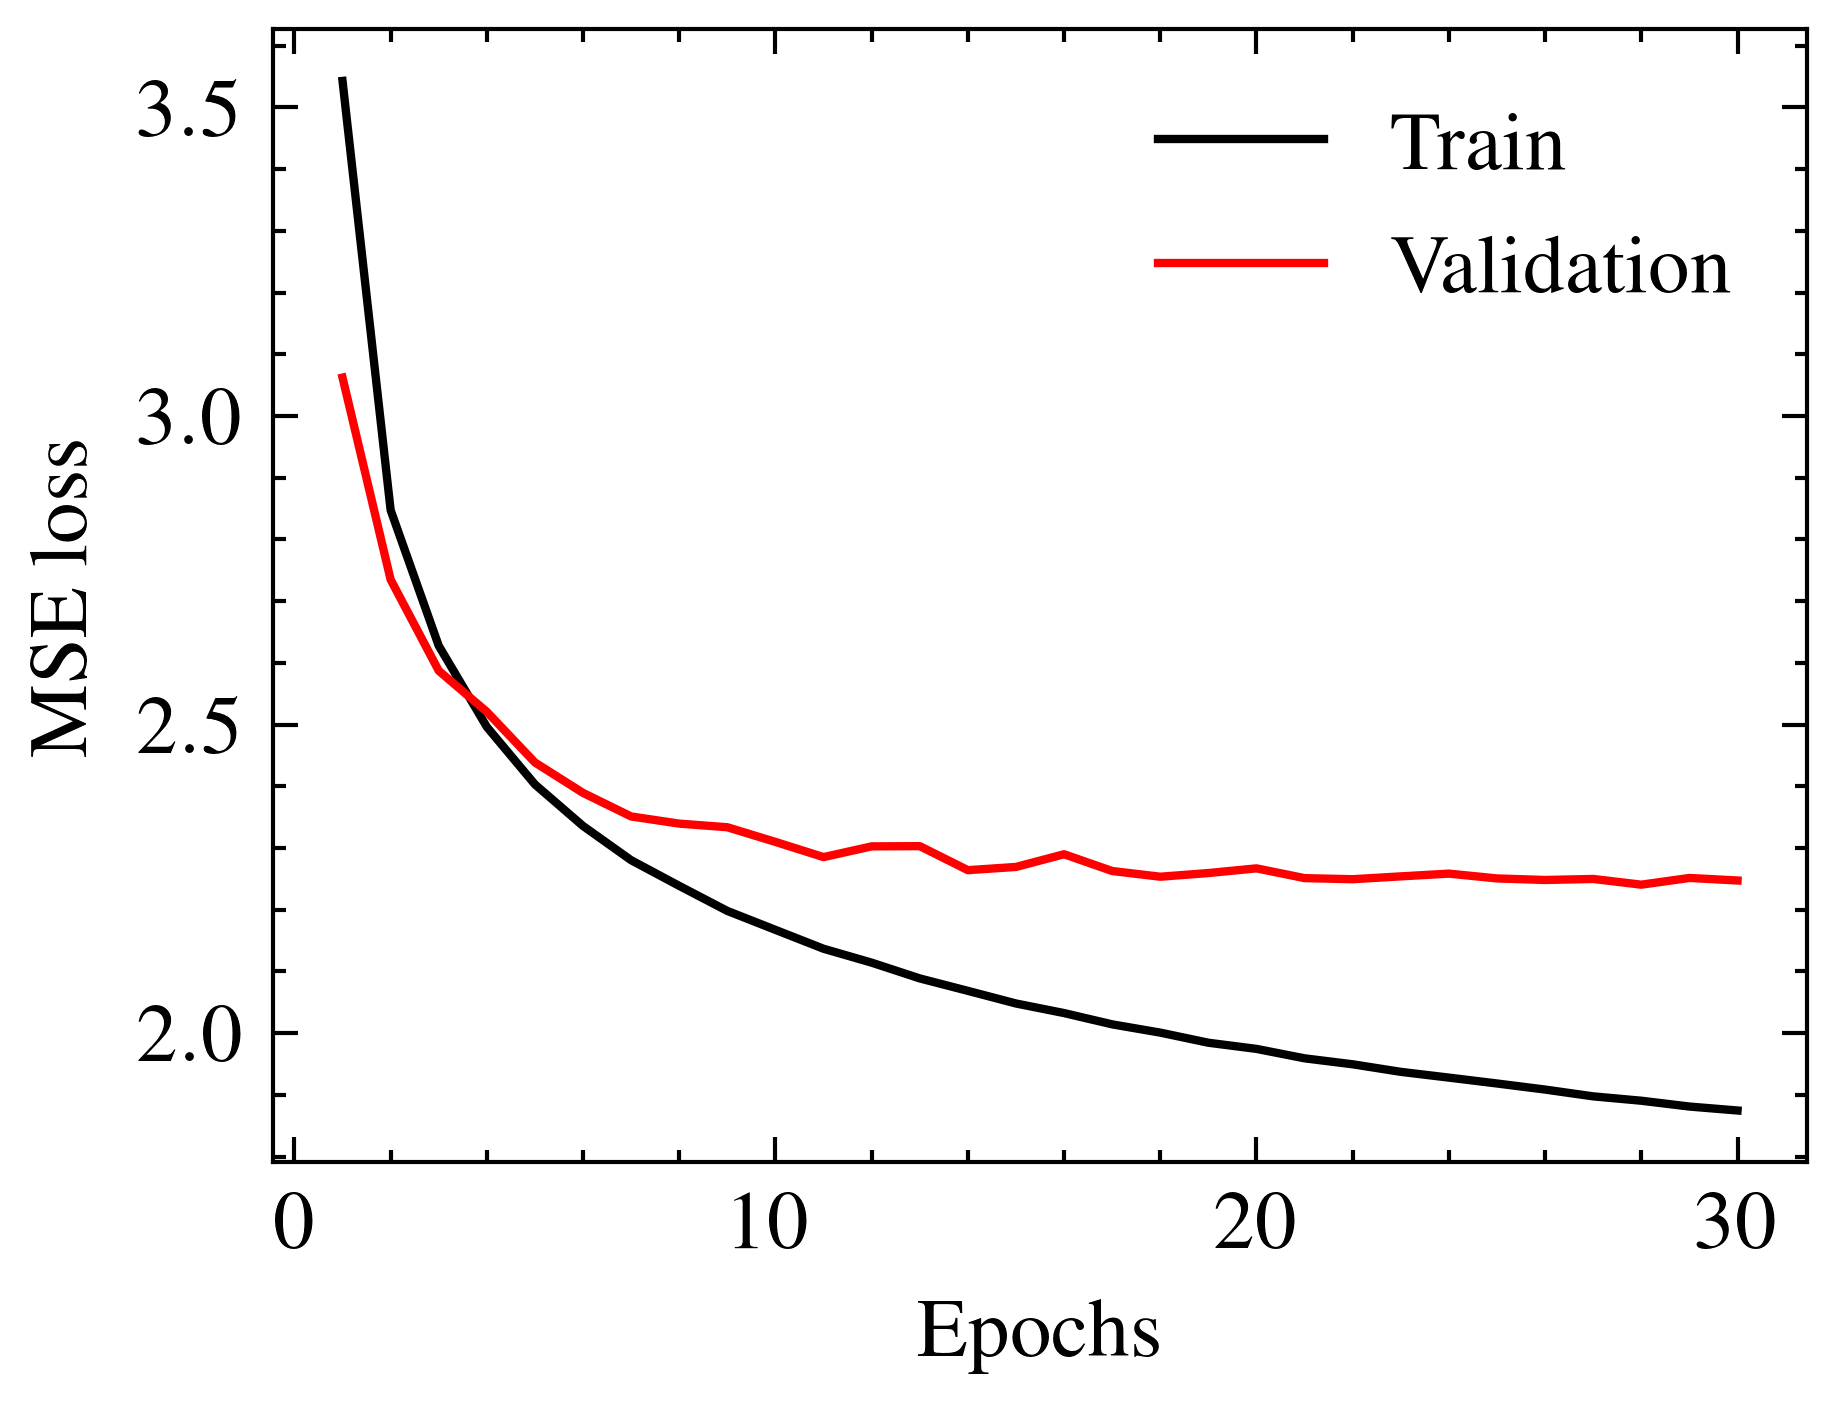

In [ ]:
plt.style.reload_library()
plt.style.use(['science', 'ieee'])
train_loss = torch.load('/content/drive/My Drive/data_audio/losses/train_loss_suplstm.pth')
val_loss = torch.load('/content/drive/My Drive/data_audio/losses/val_loss_suplstm.pth')

train_loss = (16/17000)*np.array(train_loss)
val_loss = (16/3000)*np.array(val_loss)

matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
matplotlib.rcParams.update({'font.size': 10})
plt.figure()
plt.plot(np.arange(1, 31, 1), train_loss, '-', label = 'Train')
plt.plot(np.arange(1, 31, 1), val_loss, '-', label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.legend()

# Qualitative Evaluation

In [ ]:
def evaluate_qualitative(net, audio_path, num_example, speech_rate=16000):
  """
  net: LSTM based model on CPU
  audio_dirs: list of directories containing reverberant spectrograms, clean spectrograms,
              reverberant waveforms and clean waveforms respectively
  num_example: example number in data
  speech_rate: sampling rate of speech data  
  """
  matplotlib.rc('xtick', labelsize=15)  
  matplotlib.rc('ytick', labelsize=15)
  matplotlib.rcParams.update({'font.size': 15})
  plt.rcParams["font.family"] = "serif"

  waves_rev = torch.load(audio_path[0])
  waves_target = torch.load(audio_path[1])

  rev_spec = generate_spec(waves_rev[num_example], speech_rate)
  clean_spec = generate_spec(waves_target[num_example], speech_rate)

  net.eval()
  example_rev, _ = split_for_supression(torch.tensor(rev_spec[None,None,:,:], dtype=torch.float32), None)
  example_rev_norm, stats = normalize_per_frame(example_rev)
  spec_test_response = net(example_rev_norm).cpu().detach()
  spec_test_response = denormalize_per_frame(spec_test_response, stats[0], stats[1]).numpy()

  graph_spec(clean_spec)
  graph_spec(rev_spec)
  graph_spec(spec_test_response)

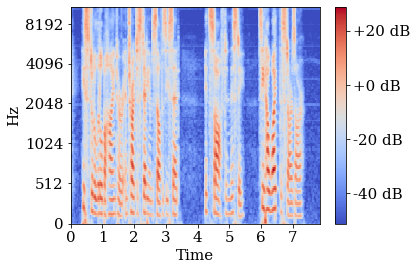

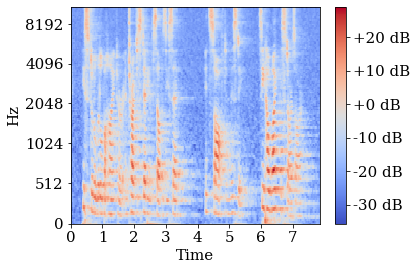

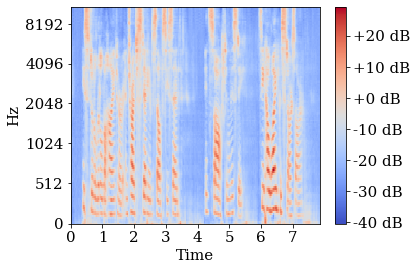

In [ ]:
net = SupLSTM()
net.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/suplstm_state_dict.pth', map_location=lambda storage, loc: storage))
paths = ['/content/drive/My Drive/data_audio/non_norm_data/waverev.pth', '/content/drive/My Drive/data_audio/non_norm_data/wavetarget.pth']
evaluate_qualitative(net, paths, 100)

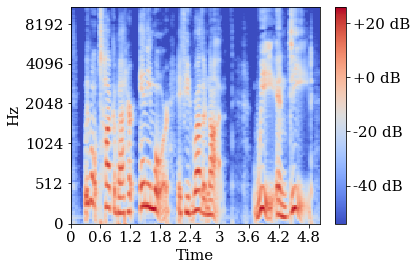

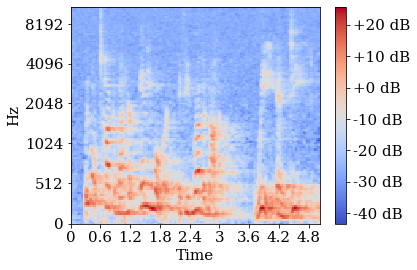

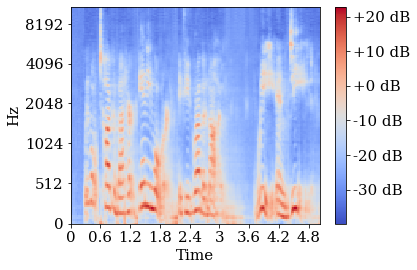

In [ ]:
net = SupLSTM()
net.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/suplstm_state_dict.pth', map_location=lambda storage, loc: storage))
paths = ['/content/drive/My Drive/data_audio/non_norm_data/waverev.pth', '/content/drive/My Drive/data_audio/non_norm_data/wavetarget.pth']
evaluate_qualitative(net, paths, 300)

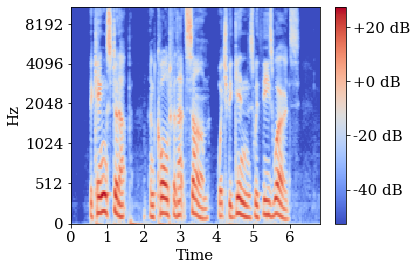

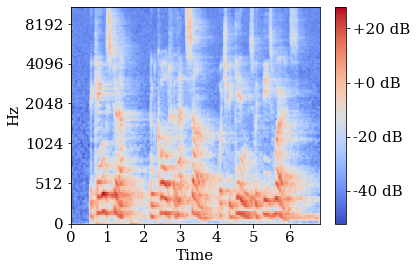

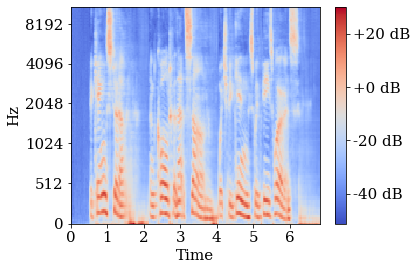

In [ ]:
net = SupLSTM()
net.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/suplstm_state_dict.pth', map_location=lambda storage, loc: storage))
paths = ['/content/drive/My Drive/data_audio/non_norm_data/waverev.pth', '/content/drive/My Drive/data_audio/non_norm_data/wavetarget.pth']
evaluate_qualitative(net, paths, 400)

In [ ]:
!pip3 install https://github.com/schmiph2/pysepm/archive/master.zip

     / 2.0MB 1.9MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     | 71kB 47.2MB/s
     / 286kB 71.1MB/s
     - 65.4MB 47kB/s
     |████████████████████████████████| 163kB 6.0MB/s 
  Created wheel for pysepm: filename=pysepm-0.1-cp37-none-any.whl size=24291 sha256=66f893b38f269ab4a5d30e42bd558d107b46d0e0800f0688b03745b1e2d24010
  Stored in directory: /tmp/pip-ephem-wheel-cache-ojlx5qfu/wheels/17/75/23/17712e0da834688ac430e0cf826dd1f7450d0b4873e0269f7c
Successfully built pysepm
  Created wheel for pystoi: filename=pystoi-0.3.3-py2.py3-none-any.whl size=7781 sha256=b1486b639903e5343714499b289ed43358254c3a43efcafafb8e8b1f77844968
  Stored in directory: /root/.cache/pip/wheels/6b/6c/b2/d49af4b7ee4ce275cf2511484b043e09b9cb7ae90c1accb17a
  Created wheel for SRMRpy: filename=SRMRpy-1.0-cp37-none-any.whl size=9397 sha256=f1593e89d400ad336c511753acb5ed46a803790fc6959332b8ed52ac5150f562
  Stored in directory: /t

In [ ]:
!pip install pystoi
!pip install pypesq
from pysepm import llr, cepstrum_distance, fwSNRseg, srmr 
from pystoi import stoi
from pypesq import pesq

  Created wheel for pypesq: filename=pypesq-1.2.4-cp37-cp37m-linux_x86_64.whl size=84246 sha256=af626d1c67d0706ab7d0131b801034b805c9440a35f7739ef66cbdef14c4d546
  Stored in directory: /root/.cache/pip/wheels/c9/29/a6/ed19583426cffac50b3e75160f894120a49f9bafa585a2edbe
Successfully built pypesq


# Quantitative Evaluation

In [ ]:
def evaluate(net, path_results, path_waves, init_example, end_example, speech_rate = 16000, initial = True, normalize_data = True):
  """
  net: LSTM model to evaluate
  path_results: base directory to save results
  path_waves: list of 2 paths representing target and reverb waveforms respectively 
  init_example: first example in waveforms to be considered
  end_example: last example in waveforms to be considered
  speech_rate: sampling rate of speech audios
  initial: True if is the first time executing, False if is not the first time
           if is False the new results are added to the existing results
  normalize_data: True if the net assumed normalized input 
  """
   
  device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
  print('Current device: ' + str(device))
 
  if (initial):
    reverb_pesq_list = []
    reverb_stoi_list = []
    reverb_llr_list = []
    reverb_cd_list = []
    reverb_fwSNRseg_list = []
    reverb_srmr_list = []

    dereverb_pesq_list = []
    dereverb_stoi_list = []
    dereverb_llr_list = []
    dereverb_cd_list = []
    dereverb_fwSNRseg_list = []
    dereverb_srmr_list = []
  
  else:
    reverb_pesq_list = torch.load(path_results + 'reverb_pesq_suplstm.pth')
    reverb_stoi_list = torch.load(path_results + 'reverb_stoi_suplstm.pth')
    reverb_llr_list = torch.load(path_results + 'reverb_llr_suplstm.pth')
    reverb_cd_list = torch.load(path_results + 'reverb_cd_suplstm.pth')
    reverb_fwSNRseg_list = torch.load(path_results + 'reverb_fwSNRseg_suplstm.pth')
    reverb_srmr_list = torch.load(path_results + 'reverb_srmr_suplstm.pth')

    dereverb_pesq_list = torch.load(path_results + 'dereverb_pesq_suplstm.pth')
    dereverb_stoi_list = torch.load(path_results + 'dereverb_stoi_suplstm.pth')
    dereverb_llr_list = torch.load(path_results + 'dereverb_llr_suplstm.pth')
    dereverb_cd_list = torch.load(path_results + 'dereverb_cd_suplstm.pth')
    dereverb_fwSNRseg_list = torch.load(path_results + 'dereverb_fwSNRseg_suplstm.pth')
    dereverb_srmr_list = torch.load(path_results + 'dereverb_srmr_suplstm.pth')

  clean_waves = torch.load(path_waves[0])
  rev_waves = torch.load(path_waves[1])
  net.eval()
  for i in range(init_example, end_example):
    print('Processing specgram n°:' + str(i+1))
    real_spec = generate_spec(clean_waves[i], speech_rate)
    rev_spec = generate_spec(rev_waves[i], speech_rate)
  
    rev_copy = torch.tensor(rev_spec[None, None, :, :], dtype = torch.float32)
    target_copy = torch.tensor(real_spec[None, None, :, :], dtype = torch.float32)
    rev_copy, target_copy = split_for_supression(rev_copy, target_copy) 
  
    if (normalize_data):
            
      #normalize
      norm_example, norm_stats_rev = normalize_per_frame(rev_copy)
      norm_target, norm_stats_target = normalize_per_frame(target_copy)
          
      spec_test_response = net(norm_example.to(device)).cpu().detach()
      spec_test_response = denormalize_per_frame(spec_test_response, norm_stats_rev[0], norm_stats_rev[1])
      spec_test_response = spec_test_response.numpy()
      targets = denormalize_per_frame(norm_target, norm_stats_target[0], norm_stats_target[1])

    else:
      spec_test_response = net(rev_copy.to(device)).cpu().detach().numpy().T
      targets = torch.clone(target_copy)
    
    original = reconstruct_wave(targets.numpy())
    reverb = rev_waves[i]
    recon = reconstruct_wave(spec_test_response)

    try:
      #metrics
      pesq_metric_rev = pesq(clean_waves[i][0:len(reverb)], reverb, speech_rate)
      stoi_metric_rev = stoi(clean_waves[i][0:len(reverb)], reverb, speech_rate)
      llr_metric_rev = llr(clean_waves[i][0:len(reverb)], reverb, speech_rate)
      cd_metric_rev = cepstrum_distance(clean_waves[i][0:len(reverb)], reverb, speech_rate)
      fwSNRseg_metric_rev = fwSNRseg(clean_waves[i][0:len(reverb)], reverb, speech_rate)
      srmr_metric_rev = srmr(reverb, speech_rate)

      pesq_metric_recon = pesq(original[0:len(recon)], recon, fs = speech_rate)
      stoi_metric_recon = stoi(original[0:len(recon)], recon, speech_rate)
      llr_metric_recon = llr(original[0:len(recon)], recon, speech_rate)
      cd_metric_recon = cepstrum_distance(original[0:len(recon)], recon, speech_rate)
      fwSNRseg_metric_recon = fwSNRseg(original[0:len(recon)], recon, speech_rate)
      srmr_metric_recon = srmr(recon, speech_rate)

      reverb_pesq_list.append(pesq_metric_rev)
      reverb_stoi_list.append(stoi_metric_rev)
      reverb_llr_list.append(llr_metric_rev)
      reverb_cd_list.append(cd_metric_rev)
      reverb_fwSNRseg_list.append(fwSNRseg_metric_rev)
      reverb_srmr_list.append(srmr_metric_rev)

      dereverb_pesq_list.append(pesq_metric_recon)
      dereverb_stoi_list.append(stoi_metric_recon)
      dereverb_llr_list.append(llr_metric_recon)
      dereverb_cd_list.append(cd_metric_recon)
      dereverb_fwSNRseg_list.append(fwSNRseg_metric_recon)
      dereverb_srmr_list.append(srmr_metric_recon)

      print('PESQ reverberated signal: {:.3f} || PESQ dereverberated signal: {:.3f}'.format(pesq_metric_rev, pesq_metric_recon))
      print('STOI reverberated signal: {:.3f} || STOI dereverberated signal: {:.3f}'.format(stoi_metric_rev, stoi_metric_recon))
      print('LLR reverberated signal: {:.3f} || LLR dereverberated signal: {:.3f}'.format(llr_metric_rev, llr_metric_recon))
      print('CD reverberated signal: {:.3f} || CD dereverberated signal: {:.3f}'.format(cd_metric_rev, cd_metric_recon))
      print('fwSNRseg reverberated signal: {:.3f} || fwSNRseg dereverberated signal: {:.3f}'.format(fwSNRseg_metric_rev, fwSNRseg_metric_recon))
      print('SRMR reverberated signal: {:.3f} || SRMR dereverberated signal: {:.3f}'.format(srmr_metric_rev, srmr_metric_recon))
      print('\n')
    
    except librosa.feature.inverse.ParameterError:
      pass


    if ((i+1)%10 == 0):
      torch.save(reverb_pesq_list, path_results + 'reverb_pesq_suplstm.pth')
      torch.save(reverb_stoi_list, path_results + 'reverb_stoi_suplstm.pth')
      torch.save(reverb_llr_list, path_results + 'reverb_llr_suplstm.pth')
      torch.save(reverb_cd_list, path_results + 'reverb_cd_suplstm.pth')
      torch.save(reverb_fwSNRseg_list, path_results + 'reverb_fwSNRseg_suplstm.pth')
      torch.save(reverb_srmr_list, path_results + 'reverb_srmr_suplstm.pth')

      torch.save(dereverb_pesq_list, path_results + 'dereverb_pesq_suplstm.pth')
      torch.save(dereverb_stoi_list, path_results + 'dereverb_stoi_suplstm.pth')
      torch.save(dereverb_llr_list, path_results + 'dereverb_llr_suplstm.pth')
      torch.save(dereverb_cd_list, path_results + 'dereverb_cd_suplstm.pth')
      torch.save(dereverb_fwSNRseg_list, path_results + 'dereverb_fwSNRseg_suplstm.pth')
      torch.save(dereverb_srmr_list, path_results + 'dereverb_srmr_suplstm.pth')
      
      print('Saved')

# Simulated Room 1

In [ ]:
model_lstm = SupLSTM()
model_lstm.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/suplstm_state_dict.pth', map_location=lambda storage, loc: storage))

path = '/content/drive/My Drive/metrics_audio/room1/norm_models/'
path_waves = ['/content/drive/My Drive/data_audio/non_norm_data/wavetarget.pth', '/content/drive/My Drive/data_audio/non_norm_data/waverev.pth']
evaluate(model_lstm, path, path_waves, 0, 500, initial = True, normalize_data = True)

Current device: cpu
Processing specgram n°:1
PESQ reverberated signal: 2.241 || PESQ dereverberated signal: 2.467
STOI reverberated signal: 0.840 || STOI dereverberated signal: 0.764
LLR reverberated signal: 0.341 || LLR dereverberated signal: 0.365
CD reverberated signal: 3.498 || CD dereverberated signal: 3.274
fwSNRseg reverberated signal: 9.593 || fwSNRseg dereverberated signal: 9.971
SRMR reverberated signal: 2.961 || SRMR dereverberated signal: 4.171


Processing specgram n°:2
PESQ reverberated signal: 2.171 || PESQ dereverberated signal: 2.313
STOI reverberated signal: 0.808 || STOI dereverberated signal: 0.746
LLR reverberated signal: 0.377 || LLR dereverberated signal: 0.377
CD reverberated signal: 3.738 || CD dereverberated signal: 3.354
fwSNRseg reverberated signal: 8.344 || fwSNRseg dereverberated signal: 9.252
SRMR reverberated signal: 3.543 || SRMR dereverberated signal: 3.914


Processing specgram n°:3
PESQ reverberated signal: 2.146 || PESQ dereverberated signal: 2.384


In [ ]:
path = '/content/drive/My Drive/metrics_audio/room1/norm_models/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_suplstm.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_suplstm.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_suplstm.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_suplstm.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_suplstm.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_suplstm.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_suplstm.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_suplstm.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_suplstm.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_suplstm.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_suplstm.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_suplstm.pth')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.11
STOI: 0.84
LLR: 0.81
CD: 5.39
fwSNRseg: 7.69
SRMR: 3.17

Dereverberated signal:
PESQ: 2.13
STOI: 0.75
LLR: 0.69
CD: 4.53
fwSNRseg: 7.72
SRMR: 3.89


## Simulated room 2

In [ ]:
model_lstm = SupLSTM()
model_lstm.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/suplstm_state_dict.pth', map_location=lambda storage, loc: storage))

path = '/content/drive/My Drive/metrics_audio/room2/norm_models/'
path_waves = ['/content/drive/My Drive/data_audio/non_norm_data/wavetarget_2.pth', '/content/drive/My Drive/data_audio/non_norm_data/waverev_2.pth']
evaluate(model_lstm, path, path_waves, 0, 500, initial = True, normalize_data = True)

Current device: cpu
Processing specgram n°:1
PESQ reverberated signal: 2.296 || PESQ dereverberated signal: 2.156
STOI reverberated signal: 0.614 || STOI dereverberated signal: 0.593
LLR reverberated signal: 1.095 || LLR dereverberated signal: 1.008
CD reverberated signal: 6.273 || CD dereverberated signal: 5.550
fwSNRseg reverberated signal: 7.129 || fwSNRseg dereverberated signal: 6.814
SRMR reverberated signal: 2.991 || SRMR dereverberated signal: 2.797


Processing specgram n°:2
PESQ reverberated signal: 2.240 || PESQ dereverberated signal: 2.197
STOI reverberated signal: 0.670 || STOI dereverberated signal: 0.630
LLR reverberated signal: 1.256 || LLR dereverberated signal: 1.032
CD reverberated signal: 6.942 || CD dereverberated signal: 5.477
fwSNRseg reverberated signal: 6.317 || fwSNRseg dereverberated signal: 6.421
SRMR reverberated signal: 2.799 || SRMR dereverberated signal: 2.875


Processing specgram n°:3
PESQ reverberated signal: 2.191 || PESQ dereverberated signal: 2.030


/usr/local/lib/python3.7/dist-packages/librosa/feature/inverse.py:89: RuntimeWarning: invalid value encountered in power
  return np.power(inverse, 1.0 / power, out=inverse)


ParameterError: ignored

In [ ]:
model_lstm = SupLSTM()
model_lstm.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/suplstm_state_dict.pth', map_location=lambda storage, loc: storage))

path = '/content/drive/My Drive/metrics_audio/room2/norm_models/'
path_waves = ['/content/drive/My Drive/data_audio/non_norm_data/wavetarget_2.pth', '/content/drive/My Drive/data_audio/non_norm_data/waverev_2.pth']
evaluate(model_lstm, path, path_waves, 180, 500, initial = False, normalize_data = True)

Current device: cpu
Processing specgram n°:181
PESQ reverberated signal: 2.151 || PESQ dereverberated signal: 1.999
STOI reverberated signal: 0.693 || STOI dereverberated signal: 0.606
LLR reverberated signal: 0.991 || LLR dereverberated signal: 0.955
CD reverberated signal: 5.989 || CD dereverberated signal: 5.505
fwSNRseg reverberated signal: 7.468 || fwSNRseg dereverberated signal: 6.945
SRMR reverberated signal: 3.523 || SRMR dereverberated signal: 3.828


Processing specgram n°:182
PESQ reverberated signal: 2.089 || PESQ dereverberated signal: 1.973
STOI reverberated signal: 0.647 || STOI dereverberated signal: 0.596
LLR reverberated signal: 1.022 || LLR dereverberated signal: 0.936
CD reverberated signal: 6.198 || CD dereverberated signal: 5.596
fwSNRseg reverberated signal: 7.524 || fwSNRseg dereverberated signal: 7.180
SRMR reverberated signal: 8.613 || SRMR dereverberated signal: 6.931


Processing specgram n°:183
PESQ reverberated signal: 2.140 || PESQ dereverberated signal: 

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room2/norm_models/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_suplstm.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_suplstm.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_suplstm.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_suplstm.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_suplstm.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_suplstm.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_suplstm.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_suplstm.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_suplstm.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_suplstm.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_suplstm.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_suplstm.pth')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.15
STOI: 0.67
LLR: 0.97
CD: 5.71
fwSNRseg: 6.58
SRMR: 4.49

Dereverberated signal:
PESQ: 2.07
STOI: 0.60
LLR: 0.92
CD: 5.29
fwSNRseg: 6.64
SRMR: 4.12


## Simulared room 3

In [ ]:
model_lstm = SupLSTM()
model_lstm.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/suplstm_state_dict.pth', map_location=lambda storage, loc: storage))

path = '/content/drive/My Drive/metrics_audio/room3/norm_models/'
path_waves = ['/content/drive/My Drive/data_audio/non_norm_data/wavetarget_3.pth', '/content/drive/My Drive/data_audio/non_norm_data/waverev_3.pth']
evaluate(model_lstm, path, path_waves, 0, 500, initial = True, normalize_data = True)

Current device: cpu
Processing specgram n°:1
PESQ reverberated signal: 2.574 || PESQ dereverberated signal: 2.356
STOI reverberated signal: 0.762 || STOI dereverberated signal: 0.743
LLR reverberated signal: 1.021 || LLR dereverberated signal: 0.905
CD reverberated signal: 6.051 || CD dereverberated signal: 5.308
fwSNRseg reverberated signal: 9.153 || fwSNRseg dereverberated signal: 8.012
SRMR reverberated signal: 3.481 || SRMR dereverberated signal: 3.370


Processing specgram n°:2
PESQ reverberated signal: 2.540 || PESQ dereverberated signal: 2.456
STOI reverberated signal: 0.799 || STOI dereverberated signal: 0.796
LLR reverberated signal: 1.174 || LLR dereverberated signal: 0.984
CD reverberated signal: 6.630 || CD dereverberated signal: 5.345
fwSNRseg reverberated signal: 7.911 || fwSNRseg dereverberated signal: 7.381
SRMR reverberated signal: 3.663 || SRMR dereverberated signal: 3.529


Processing specgram n°:3
PESQ reverberated signal: 2.588 || PESQ dereverberated signal: 2.359


In [ ]:
path = '/content/drive/My Drive/metrics_audio/room3/norm_models/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_suplstm.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_suplstm.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_suplstm.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_suplstm.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_suplstm.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_suplstm.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_suplstm.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_suplstm.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_suplstm.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_suplstm.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_suplstm.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_suplstm.pth')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.57
STOI: 0.83
LLR: 0.85
CD: 5.25
fwSNRseg: 8.68
SRMR: 5.21

Dereverberated signal:
PESQ: 2.38
STOI: 0.77
LLR: 0.81
CD: 4.97
fwSNRseg: 8.06
SRMR: 4.53


## Simulated room 4

In [ ]:
model_lstm = SupLSTM()
model_lstm.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/suplstm_state_dict.pth', map_location=lambda storage, loc: storage))

path = '/content/drive/My Drive/metrics_audio/room4/norm_models/'
path_waves = ['/content/drive/My Drive/data_audio/non_norm_data/wavetarget_4.pth', '/content/drive/My Drive/data_audio/non_norm_data/waverev_4.pth']
evaluate(model_lstm, path, path_waves, 0, 500, initial = True, normalize_data = True)

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room4/norm_models/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_suplstm.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_suplstm.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_suplstm.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_suplstm.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_suplstm.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_suplstm.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_suplstm.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_suplstm.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_suplstm.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_suplstm.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_suplstm.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_suplstm.pth')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.17
STOI: 0.85
LLR: 0.59
CD: 4.69
fwSNRseg: 8.12
SRMR: 3.15

Dereverberated signal:
PESQ: 2.25
STOI: 0.77
LLR: 0.52
CD: 4.04
fwSNRseg: 8.34
SRMR: 4.74


## Simulated room 5

In [ ]:
model_lstm = SupLSTM()
model_lstm.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/suplstm_state_dict.pth', map_location=lambda storage, loc: storage))

path = '/content/drive/My Drive/metrics_audio/room5/norm_models/'
path_waves = ['/content/drive/My Drive/data_audio/non_norm_data/wavetarget_5.pth', '/content/drive/My Drive/data_audio/non_norm_data/waverev_5.pth']
evaluate(model_lstm, path, path_waves, 0, 500, initial = True, normalize_data = True)

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room5/norm_models/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_suplstm.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_suplstm.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_suplstm.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_suplstm.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_suplstm.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_suplstm.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_suplstm.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_suplstm.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_suplstm.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_suplstm.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_suplstm.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_suplstm.pth')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 1.97
STOI: 0.80
LLR: 1.36
CD: 7.30
fwSNRseg: 6.38
SRMR: 3.08

Dereverberated signal:
PESQ: 1.86
STOI: 0.71
LLR: 1.18
CD: 6.17
fwSNRseg: 5.98
SRMR: 2.71


In [ ]:
def evaluate_realdata(net, path_results, path_waves, init_example, end_example, speech_rate = 16000, initial = True, normalize_data = True):
  """
  net: LSTM based model to evaluate
  path_results: base directory to save results
  path_waves: path representing reverb waveforms 
  init_example: first example in dataset to be considered
  end_example: last example in dataset to be considered
  speech_rate: sampling rate of speech audios
  initial: True if is the first time executing, False if is not the first time
           if is False the new results are added to the existing results
  normalize_data: True if the net assume normalized input 
  """

  device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
  print('Current device: ' + str(device))
 
  if (initial):
    reverb_srmr_list = []
    dereverb_srmr_list = []
  
  else:
    reverb_srmr_list = torch.load(path_results + 'reverb_srmr_suplstm.pth')
    dereverb_srmr_list = torch.load(path_results + 'dereverb_srmr_suplstm.pth')

  waves = torch.load(path_waves)
  net.eval()
  for i in range(init_example, end_example):
    print('Processing specgram n°:' + str(i+1))
    rev_spec = generate_spec(waves[i], speech_rate)
    rev_copy = torch.tensor(rev_spec[None, None, :, :], dtype = torch.float32)
    rev_copy, _ = split_for_supression(rev_copy, None) 
    if (normalize_data):
      #normalize
      norm_example, norm_stats_rev = normalize_per_frame(rev_copy)          
      spec_test_response = net(norm_example.to(device)).cpu().detach()
      spec_test_response = denormalize_per_frame(spec_test_response, norm_stats_rev[0], norm_stats_rev[1])
      spec_test_response = spec_test_response.numpy()

    else:
      spec_test_response = net(rev_copy.to(device)).cpu().detach().numpy().T
    
    #SRMR evaluation
    recon = reconstruct_wave(spec_test_response)
    
    srmr_metric_rev = srmr(waves[i], speech_rate)
    srmr_metric_recon = srmr(recon, speech_rate)

    reverb_srmr_list.append(srmr_metric_rev)
    dereverb_srmr_list.append(srmr_metric_recon)

    print('SRMR reverberated signal: {:.3f} || SRMR dereverberated signal: {:.3f}'.format(srmr_metric_rev, srmr_metric_recon))
    print('\n')

    if ((i+1)%10 == 0):

      torch.save(reverb_srmr_list, path_results + 'reverb_srmr_suplstm.pth')
      torch.save(dereverb_srmr_list, path_results + 'dereverb_srmr_suplstm.pth')
      
      print('Saved')

## Far data

In [ ]:
path = '/content/drive/My Drive/real_data/far_data/norm_models/'
path_waves = '/content/drive/My Drive/real_data/waves2'
model_lstm = SupLSTM()
model_lstm.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/suplstm_state_dict.pth', map_location=lambda storage, loc: storage))

evaluate_realdata(model_lstm, path, path_waves, 0, 500, initial = True, normalize_data=True)

Current device: cpu
Processing specgram n°:1
SRMR reverberated signal: 3.544 || SRMR dereverberated signal: 4.631


Processing specgram n°:2
SRMR reverberated signal: 5.083 || SRMR dereverberated signal: 6.049


Processing specgram n°:3
SRMR reverberated signal: 4.067 || SRMR dereverberated signal: 5.637


Processing specgram n°:4
SRMR reverberated signal: 3.647 || SRMR dereverberated signal: 5.406


Processing specgram n°:5
SRMR reverberated signal: 5.406 || SRMR dereverberated signal: 7.246


Processing specgram n°:6
SRMR reverberated signal: 3.478 || SRMR dereverberated signal: 5.995


Processing specgram n°:7
SRMR reverberated signal: 5.542 || SRMR dereverberated signal: 7.150


Processing specgram n°:8
SRMR reverberated signal: 2.970 || SRMR dereverberated signal: 5.155


Processing specgram n°:9
SRMR reverberated signal: 7.028 || SRMR dereverberated signal: 4.891


Processing specgram n°:10
SRMR reverberated signal: 5.625 || SRMR dereverberated signal: 6.503


Saved
Processing sp

In [ ]:
path = '/content/drive/My Drive/real_data/far_data/norm_models/'
path_waves = '/content/drive/My Drive/real_data/waves2'
model_lstm = SupLSTM()
model_lstm.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/suplstm_state_dict.pth', map_location=lambda storage, loc: storage))

evaluate_realdata(model_lstm, path, path_waves, 400, 500, initial = False, normalize_data=True)

Current device: cpu
Processing specgram n°:401
SRMR reverberated signal: 4.503 || SRMR dereverberated signal: 11.920


Processing specgram n°:402
SRMR reverberated signal: 3.500 || SRMR dereverberated signal: 13.122


Processing specgram n°:403
SRMR reverberated signal: 6.247 || SRMR dereverberated signal: 19.987


Processing specgram n°:404
SRMR reverberated signal: 5.905 || SRMR dereverberated signal: 10.454


Processing specgram n°:405
SRMR reverberated signal: 4.017 || SRMR dereverberated signal: 19.146


Processing specgram n°:406
SRMR reverberated signal: 4.158 || SRMR dereverberated signal: 14.736


Processing specgram n°:407
SRMR reverberated signal: 5.309 || SRMR dereverberated signal: 12.749


Processing specgram n°:408
SRMR reverberated signal: 5.223 || SRMR dereverberated signal: 17.510


Processing specgram n°:409
SRMR reverberated signal: 6.357 || SRMR dereverberated signal: 7.082


Processing specgram n°:410
SRMR reverberated signal: 5.134 || SRMR dereverberated signal: 

In [ ]:
path = '/content/drive/My Drive/real_data/far_data/norm_models/'
reverb_srmr_list = torch.load(path + 'reverb_srmr_suplstm.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_suplstm.pth')

print('Results: \n')
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

SRMR: 4.36

Dereverberated signal:
SRMR: 8.16


## Near data

In [ ]:
path = '/content/drive/My Drive/real_data/near_data/norm_models/'
path_waves = '/content/drive/My Drive/real_data/waves1'
model_lstm = SupLSTM()
model_lstm.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/suplstm_state_dict.pth', map_location=lambda storage, loc: storage))

evaluate_realdata(model_lstm, path, path_waves, 0, 500, initial = True, normalize_data=True)

Current device: cpu
Processing specgram n°:1
SRMR reverberated signal: 2.644 || SRMR dereverberated signal: 1.914


Processing specgram n°:2
SRMR reverberated signal: 2.455 || SRMR dereverberated signal: 2.954


Processing specgram n°:3
SRMR reverberated signal: 3.125 || SRMR dereverberated signal: 2.720


Processing specgram n°:4
SRMR reverberated signal: 2.727 || SRMR dereverberated signal: 2.691


Processing specgram n°:5
SRMR reverberated signal: 2.833 || SRMR dereverberated signal: 2.447


Processing specgram n°:6
SRMR reverberated signal: 3.089 || SRMR dereverberated signal: 3.142


Processing specgram n°:7
SRMR reverberated signal: 2.542 || SRMR dereverberated signal: 3.254


Processing specgram n°:8
SRMR reverberated signal: 2.694 || SRMR dereverberated signal: 3.367


Processing specgram n°:9
SRMR reverberated signal: 2.502 || SRMR dereverberated signal: 2.529


Processing specgram n°:10
SRMR reverberated signal: 4.001 || SRMR dereverberated signal: 3.108


Saved
Processing sp

In [ ]:
path = '/content/drive/My Drive/real_data/near_data/norm_models/'
reverb_srmr_list = torch.load(path + 'reverb_srmr_suplstm.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_suplstm.pth')

print('Results: \n')
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

SRMR: 3.99

Dereverberated signal:
SRMR: 5.49
